<a href="https://colab.research.google.com/github/Jeoniee/spartaAI/blob/main/1_3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [16]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 170M/170M [00:03<00:00, 43.8MB/s]


MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

50000
torch.Size([3, 32, 32]) 6
10000
torch.Size([3, 32, 32]) 3


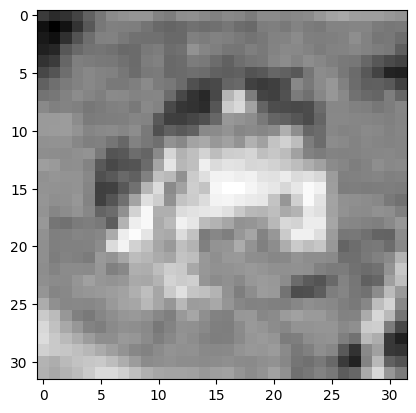

In [17]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

print(len(testset))
print(testset[0][0].shape, testset[0][1])
#plt.imshow(testset[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [35]:
batch_size = 256
lr = 0.001
n_epochs = 50


trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [36]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [37]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU(0.01)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


#model = Model(28 * 28 * 1, 1024)
model = Model(32 * 32 * 3, 1024).to('cuda') #이미지 크기가 32 * 32 * 3

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [38]:
from torch.optim import SGD, Adam

optimizer = SGD(model.parameters(), lr=lr)

# SGD, Adam Optimizer 추가
sgd_optimizer = SGD(model.parameters(), lr=lr)
adam_optimizer = Adam(model.parameters(), lr=lr)

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

Training with SGD optimizer...
Epoch 1/50 | Loss: 0.0090 | Train Accuracy: 0.1008 | Test Accuracy: 0.1010
Epoch 2/50 | Loss: 0.0090 | Train Accuracy: 0.1041 | Test Accuracy: 0.1051
Epoch 3/50 | Loss: 0.0090 | Train Accuracy: 0.1207 | Test Accuracy: 0.1204
Epoch 4/50 | Loss: 0.0089 | Train Accuracy: 0.1492 | Test Accuracy: 0.1510
Epoch 5/50 | Loss: 0.0089 | Train Accuracy: 0.1783 | Test Accuracy: 0.1796
Epoch 6/50 | Loss: 0.0089 | Train Accuracy: 0.1993 | Test Accuracy: 0.2012
Epoch 7/50 | Loss: 0.0089 | Train Accuracy: 0.2104 | Test Accuracy: 0.2142
Epoch 8/50 | Loss: 0.0088 | Train Accuracy: 0.2217 | Test Accuracy: 0.2257
Epoch 9/50 | Loss: 0.0088 | Train Accuracy: 0.2394 | Test Accuracy: 0.2434
Epoch 10/50 | Loss: 0.0088 | Train Accuracy: 0.2419 | Test Accuracy: 0.2441
Epoch 11/50 | Loss: 0.0087 | Train Accuracy: 0.2482 | Test Accuracy: 0.2523
Epoch 12/50 | Loss: 0.0087 | Train Accuracy: 0.2525 | Test Accuracy: 0.2576
Epoch 13/50 | Loss: 0.0087 | Train Accuracy: 0.2594 | Test Accurac

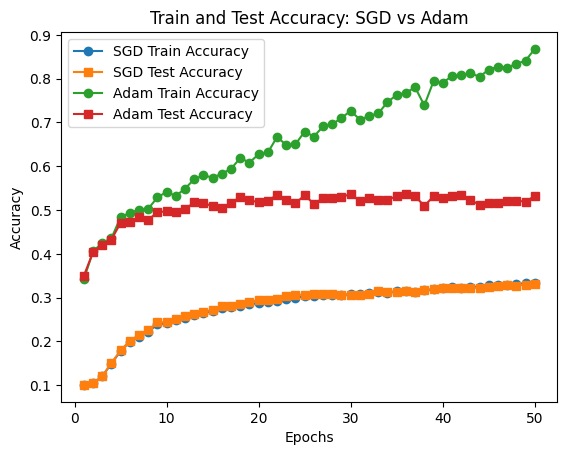

In [39]:


train_accs = []  # train 정확도 리스트
test_accs = []   # test 정확도 리스트

criterion = nn.CrossEntropyLoss()



def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    # 평가 모드로 설정 -> 너무 느려서 바꿔봄
    model.eval()

    with torch.no_grad():  # 평가 중에는 gradient 계산을 하지 않음
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)

            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()

    return acc / cnt


# 학습 함수
def train(model, optimizer):
    train_accs = []  # train 정확도 리스트
    test_accs = []   # test 정확도 리스트

    for epoch in range(n_epochs):
        model.train()  # 학습 모드 설정
        total_loss = 0.

        for data in trainloader:
            optimizer.zero_grad()  # 기울기 초기화
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            loss = criterion(preds, labels)  # CrossEntropyLoss 사용
            loss.backward()  # 역전파
            optimizer.step()  # 파라미터 업데이트

            total_loss += loss.item()

        # Epoch마다 train과 test 정확도 계산
        train_acc = accuracy(model, trainloader)
        test_acc = accuracy(model, testloader)

        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"Epoch {epoch + 1}/{n_epochs} | Loss: {total_loss / len(trainloader.dataset):.4f} | Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

    return train_accs, test_accs



# 학습 실행 (SGD 학습)
print("Training with SGD optimizer...")
sgd_train_accs, sgd_test_accs = train(model, sgd_optimizer)

# 학습 실행 (Adam 학습)
print("Training with Adam optimizer...")
adam_train_accs, adam_test_accs = train(model, adam_optimizer)

# 정확도 그래프 출력
plt.plot(range(1, 51), sgd_train_accs, label="SGD Train Accuracy", marker='o')
plt.plot(range(1, 51), sgd_test_accs, label="SGD Test Accuracy", marker='s')
plt.plot(range(1, 51), adam_train_accs, label="Adam Train Accuracy", marker='o')
plt.plot(range(1, 51), adam_test_accs, label="Adam Test Accuracy", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy: SGD vs Adam")
plt.legend()
plt.show()

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

In [ ]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

Epoch   0 | Loss: 2.2975
Epoch   1 | Loss: 2.2903
Epoch   2 | Loss: 2.2836
Epoch   3 | Loss: 2.2772
Epoch   4 | Loss: 2.2710
Epoch   5 | Loss: 2.2648
Epoch   6 | Loss: 2.2585
Epoch   7 | Loss: 2.2520
Epoch   8 | Loss: 2.2454
Epoch   9 | Loss: 2.2386
Epoch  10 | Loss: 2.2318
Epoch  11 | Loss: 2.2248
Epoch  12 | Loss: 2.2179
Epoch  13 | Loss: 2.2086
Epoch  14 | Loss: 2.1930
Epoch  15 | Loss: 2.1812
Epoch  16 | Loss: 2.1701
Epoch  17 | Loss: 2.1556
Epoch  18 | Loss: 2.1418
Epoch  19 | Loss: 2.1285
Epoch  20 | Loss: 2.1155
Epoch  21 | Loss: 2.1029
Epoch  22 | Loss: 2.0907
Epoch  23 | Loss: 2.0790
Epoch  24 | Loss: 2.0679
Epoch  25 | Loss: 2.0573
Epoch  26 | Loss: 2.0472
Epoch  27 | Loss: 2.0374
Epoch  28 | Loss: 2.0281
Epoch  29 | Loss: 2.0192
Epoch  30 | Loss: 2.0106
Epoch  31 | Loss: 2.0023
Epoch  32 | Loss: 1.9944
Epoch  33 | Loss: 1.9868
Epoch  34 | Loss: 1.9794
Epoch  35 | Loss: 1.9725
Epoch  36 | Loss: 1.9657
Epoch  37 | Loss: 1.9592
Epoch  38 | Loss: 1.9529
Epoch  39 | Loss: 1.9469


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.